In [1]:
import os
import sys
import csv
import wave
import copy
import math

import numpy as np
import pandas as pd

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.svm import OneClassSVM, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Input, Merge
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

sys.path.append("../")
from utilities.utils import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import clear_output

C:\Users\gabri\Anaconda3\envs\speech2emotion\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\gabri\Anaconda3\envs\speech2emotion\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\gabri\Anaconda3\envs\speech2emotion\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float

In [2]:
params = Constants()
print(params)

----------------------------------------------------------------------------------------------------
available_emotions            ['ang' 'exc' 'neu' 'sad']                                             
conf_matrix_prefix            iemocap                                                               
framerate                     16000                                                                 
path_to_data                  C:\Users\gabri\Documents\Deeplearning\somegit\forked\emotion_recogniti
path_to_features              C:\Users\gabri\Documents\Deeplearning\somegit\forked\emotion_recogniti
sessions                      ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']          
types                         {1: <class 'numpy.int8'>, 2: <class 'numpy.int16'>, 4: <class 'numpy.i
----------------------------------------------------------------------------------------------------


In [3]:
batch_size = 64
nb_feat = 34
nb_class = 4
nb_epoch = 80

optimizer = 'Adadelta'

# Calculating features

In [4]:
# data = read_iemocap_data(params=params)

In [5]:
# get_features(data, params)

# Model definition

In [6]:
def build_simple_lstm(nb_feat, nb_class, optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(32, nb_feat)))
    model.add(Activation('tanh'))
    model.add(LSTM(256, return_sequences=False))
    model.add(Activation('tanh'))
    model.add(Dense(512))
    model.add(Activation('tanh'))
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [7]:
def build_blstm(nb_feat, nb_class, optimizer='Adadelta'):
    net_input = Input(shape=(78, nb_feat))
    forward_lstm1  = LSTM(output_dim=64, 
                          return_sequences=True, 
                          activation="tanh"
                         )(net_input)
    backward_lstm1 = LSTM(output_dim=64, 
                          return_sequences=True, 
                          activation="tanh", 
                          go_backwards=True
                         )(net_input)
    blstm_output1  = Merge(mode='concat')([forward_lstm1, backward_lstm1])
    
    forward_lstm2  = LSTM(output_dim=64, 
                          return_sequences=False, 
                          activation="tanh"
                         )(blstm_output1)
    backward_lstm2 = LSTM(output_dim=64, 
                          return_sequences=False, 
                          activation="tanh", 
                          go_backwards=True
                         )(blstm_output1)
    blstm_output2  = Merge(mode='concat')([forward_lstm2, backward_lstm2])
    hidden = Dense(512, activation='tanh')(blstm_output2)
    output = Dense(nb_class, activation='softmax')(hidden)
    model  = Model(net_input, output)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Model building

In [8]:
model = build_simple_lstm(nb_feat, nb_class)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32, 512)           1120256   
_________________________________________________________________
activation_1 (Activation)    (None, 32, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
__________

# Data preparation

In [21]:
# X, y, valid_idxs = get_sample(ids=None, take_all=True)
mX_test, my_test, mX_train, my_train, mX_val, my_val = get_all_samples(gender = 'M')
my_train = to_categorical(my_train, params)
my_test = to_categorical(my_test, params)
my_val = to_categorical(my_val, params)

# idxs_train, idxs_test = train_test_split(range(X.shape[0]), test_size=0.2)

4936


In [22]:
mX_test, _ = pad_sequence_into_array(mX_test, maxlen=32)
mX_train, _ = pad_sequence_into_array(mX_train, maxlen=32)
mX_val, _ = pad_sequence_into_array(mX_val, maxlen=32)

In [20]:
# X_train,  = X[idxs_train], X[idxs_test]
# # y_train, y_test = y[idxs_train], y[idxs_test]
# print(X_test.shape)
# print(y_test.shape)
# print(y_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)


(585,)
(585, 4)
(1560, 4)
(1560, 4)
(469,)
(469,)


# Training

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 
checkpointer = ModelCheckpoint(filepath='MALEONLY.hdf5', verbose=1, save_best_only=True)

    
hist = model.fit(mX_train, my_train, 
                 batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, 
                 validation_data=(mX_test, my_test),  callbacks=[early_stopping, checkpointer])

C:\Users\gabri\Anaconda3\envs\speech2emotion\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1560 samples, validate on 585 samples
Epoch 1/80
1560/1560 [==============================] - 16s 11ms/step - loss: 1.2276 - acc: 0.4410 - val_loss: 1.4096 - val_acc: 0.3915

Epoch 00001: val_loss improved from inf to 1.40963, saving model to MALEONLY.hdf5
Epoch 2/80
1560/1560 [==============================] - 17s 11ms/step - loss: 1.1903 - acc: 0.4583 - val_loss: 1.2537 - val_acc: 0.3880

Epoch 00002: val_loss improved from 1.40963 to 1.25366, saving model to MALEONLY.hdf5
Epoch 3/80
1560/1560 [==============================] - 16s 10ms/step - loss: 1.1485 - acc: 0.4692 - val_loss: 1.2476 - val_acc: 0.3692

Epoch 00003: val_loss improved from 1.25366 to 1.24761, saving model to MALEONLY.hdf5
Epoch 4/80
1560/1560 [==============================] - 16s 10ms/step - loss: 1.0923 - acc: 0.4962 - val_loss: 1.2082 - val_acc: 0.4359

Epoch 00004: val_loss improved from 1.24761 to 1.20821, saving model to MALEONLY.hdf5
Epoch 5/80
1560/1560 [==============================] - 16s 11ms/

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


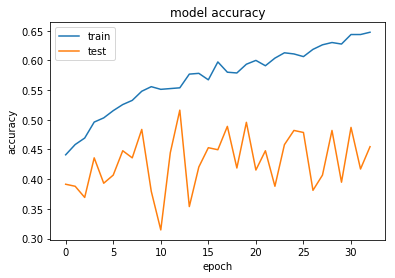

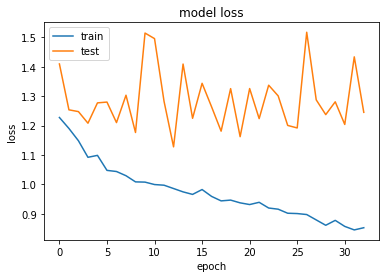

In [26]:
history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(len(test_x))